In [1]:
from keras.models import load_model

from imageio import imread
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

from keras import backend as K
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from keras.optimizers import Adam, SGD
from models.keras_ssd300 import ssd_300
from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

from eval_utils.average_precision_evaluator import Evaluator

# TODO: Specify the directory that contains the `pycocotools` here.
# pycocotools_dir = 'cocoapi/PythonAPI/'
# if pycocotools_dir not in sys.path:
#     sys.path.insert(0, pycocotools_dir)

# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval

# from eval_utils.coco_utils import get_coco_category_maps, predict_all_to_json

from tensorflow import Graph
%matplotlib inline
sns.set()

Using TensorFlow backend.


In [2]:
# Set a few configuration parameters.
# img_height = 300
# img_width = 400
# n_classes = 43
model_mode = 'inference'

In [8]:
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
dataset = DataGenerator()

# Images
images_dir = 'data/Full/'

# Ground truth
train_labels_filename = 'data/train.txt'
val_labels_filename   = 'data/test.txt'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'],
                      include_classes='all')

# classes = ['background',
#            '0', '1', '2', '3',
#            '4', '5', '6', '7',
#            '8', '9', '10', '11', '12', '13',
#            '14', '15', '16', '17',
#            '18', '19', '20', '21', '22', '23',
#            '24', '25', '26', '27',
#            '28', '29', '30', '31', '32', '33',
#            '34', '35', '36', '37',
#            '38', '39', '40', '41', '42']

# # TODO: Set the paths to the dataset here.
# Pascal_VOC_dataset_images_dir = 'data/Full/'
# Pascal_VOC_dataset_annotations_dir = 'data/voc/'
# Pascal_VOC_dataset_image_set_filename = 'data/main/main2.txt'

# dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
#                   image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
#                   annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
#                   classes=classes,
#                   include_classes='all',
#                   exclude_truncated=False,
#                   exclude_difficult=False,
#                   ret=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	   666
Number of images in the validation dataset:	    75


In [7]:
train_dataset_size

NameError: name 'train_dataset_size' is not defined

In [4]:
classes = pd.read_csv('data/classes.txt')
all_labels = pd.read_csv('data/gt.txt', sep=';')
train_labels = pd.read_csv(train_labels_filename, sep=';')
val_labels = pd.read_csv(val_labels_filename, sep=';')

In [5]:
print(all_labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 6 columns):
image_name    1213 non-null object
xmin          1213 non-null int64
xmax          1213 non-null int64
ymin          1213 non-null int64
ymax          1213 non-null int64
class_id      1213 non-null int64
dtypes: int64(5), object(1)
memory usage: 56.9+ KB
None


In [16]:
all_labels.groupby(['image_name']).count().info()

<class 'pandas.core.frame.DataFrame'>
Index: 741 entries, 00000.ppm to 00899.ppm
Data columns (total 5 columns):
xmin        741 non-null int64
xmax        741 non-null int64
ymin        741 non-null int64
ymax        741 non-null int64
class_id    741 non-null int64
dtypes: int64(5)
memory usage: 34.7+ KB


In [7]:
all_labels.head()

,image_name,xmin,xmax,ymin,ymax,class_id
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


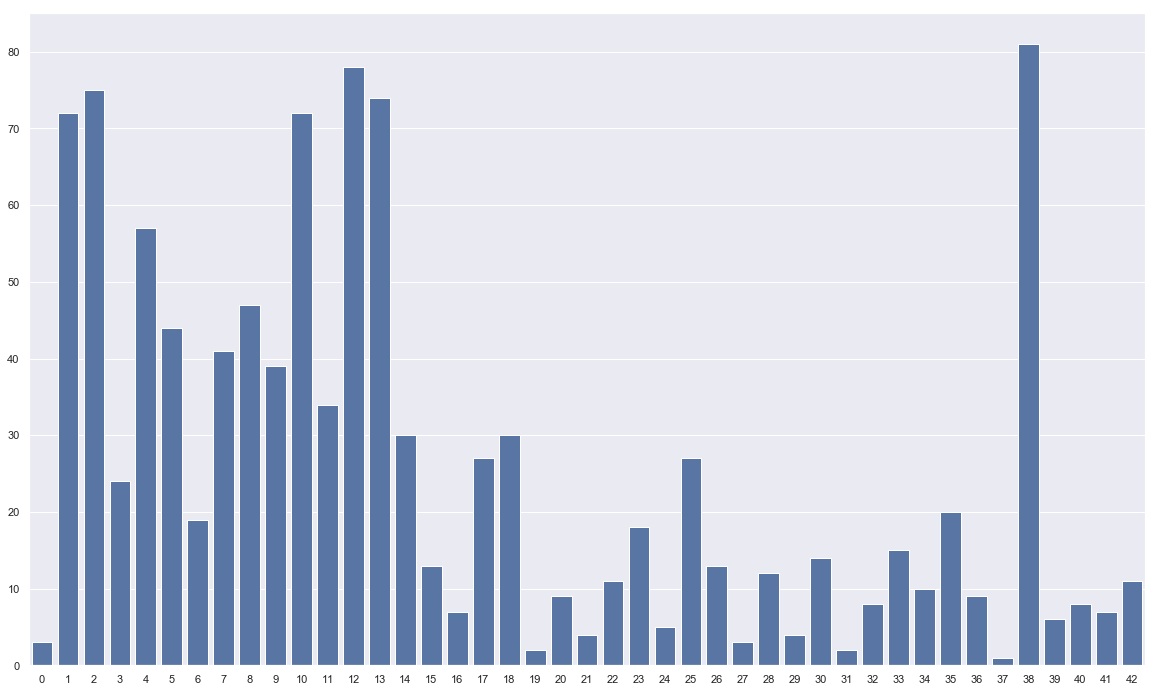

In [8]:
c = train_labels.groupby('class_id').count()
np.array(c.index)
np.array(c.image_name)
fig = plt.figure(figsize=(20,12))
sns.barplot(x=np.array(c.index), y=np.array(c.image_name), color='b')
plt.show()

In [9]:
all_labels.class_id.count()

1213

In [10]:
classes.class_name

0                             speed limit 20
1                             speed limit 30
2                             speed limit 50
3                             speed limit 60
4                             speed limit 70
5                             speed limit 80
6                        restriction ends 80
7                            speed limit 100
8                            speed limit 120
9                              no overtaking
10                    no overtaking (trucks)
11             priority at next intersection
12                             priority road
13                                  give way
14                                      stop
15                      no traffic both ways
16                                 no trucks
17                                  no entry
18                                    danger
19                                 bend left
20                                bend right
21                                      bend
22        

In [9]:
# 1: Build the Keras model
img_height = 400 # Height of the input images
img_width = 600 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 43 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords)

# 2: Optional: Load some weights

# model.load_weights('./ssd7_weights.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-4)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=['accuracy'])

In [11]:
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

In [12]:

model = load_model('Saved/ssd7_epoch-165_loss-2.4381_val_loss-3.3965.h5', custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

In [13]:
# # 1: Set the generator for the predictions.
# resize = Resize(height=img_height, width=img_width)

# predict_generator = val_dataset.generate(batch_size=val_dataset_size,
#                                          shuffle=False,
#                                          transformations=[resize],
#                                          label_encoder=None,
#                                          returns={'processed_images',
#                                                     'processed_labels',
#                                                     'filenames',
#                                                     'original_images',
#                                                     'original_labels'},
#                                          keep_images_without_gt=False)

In [14]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=val_dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 75

Producing predictions batch-wise: 100%|██████████████████| 10/10 [01:08<00:00,  5.89s/it]
Matching predictions to ground truth, class 1/43.: 100%|█| 14/14 [00:00<00:00, 611.27it/s]
No predictions for class 2/43
No predictions for class 3/43
No predictions for class 4/43
No predictions for class 5/43
No predictions for class 6/43
No predictions for class 7/43
No predictions for class 8/43
No predictions for class 9/43
No predictions for class 10/43
No predictions for class 11/43
No predictions for class 12/43
No predictions for class 13/43
No predictions for class 14/43
No predictions for class 15/43
No predictions for class 16/43
No predictions for class 17/43
No predictions for class 18/43
No predictions for class 19/43
No predictions for class 20/43
No predictions for class 21/43
No predictions for class 22/43
No predictions for class 23/43
No predictions for class 24/43
No predictions for class 25/43
No predictions for class 26/43
No p

IndexError: list index out of range

In [ ]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

In [ ]:
m = max((n_classes) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

In [ ]:
# batch_images, batch_labels, batch_filenames, original_images, original_annotations= next(predict_generator)
# y_pred = model_ssd300.predict(batch_images)
# y_pred_decoded = decode_detections(y_pred,
#                                confidence_thresh=0.5,
#                                iou_threshold=0.45,
#                                top_k=200,
#                                normalize_coords=normalize_coords,
#                                img_height=img_height,
#                                img_width=img_width)

# for i in original_annotations[i]:
#     y_true = np.array(i[0])
# y_true = np.array(original_annotations[0][0][0])
# if len(y_pred_decoded[0]) == 0:
#     y_pred = np.array(-1)
# else:
#     for j in y_pred_decoded[i]:
#         y_pred = np.array(j[0])
        
# for i in range(1, val_dataset_size):
#     for j in original_annotations[i]:
#         y_true = np.hstack((y_true, j[0]))
#     if len(y_pred_decoded[i]) == 0:
#         y_pred = np.hstack((y_pred, -1))
#     else:
#         for j in y_pred_decoded[i]:
#             y_pred = np.hstack((y_pred, j[0]))
    

In [33]:
data7 = pd.read_csv('Saved/ssd7_training_log.csv')
data300 = pd.read_csv('Saved/ssd300_pascal_07+12_training_log.csv')

In [34]:
data7.head()

,epoch,loss2,val_loss,val_loss2,loss
0,0,21.556524,15.148151,17.948151,19.456524
1,1,15.629082,13.197838,15.997838,13.529082
2,2,13.432723,11.173237,13.973237,11.332723
3,3,11.083018,8.916961,11.716961,8.983018
4,4,8.589046,6.636402,9.436402,6.489046


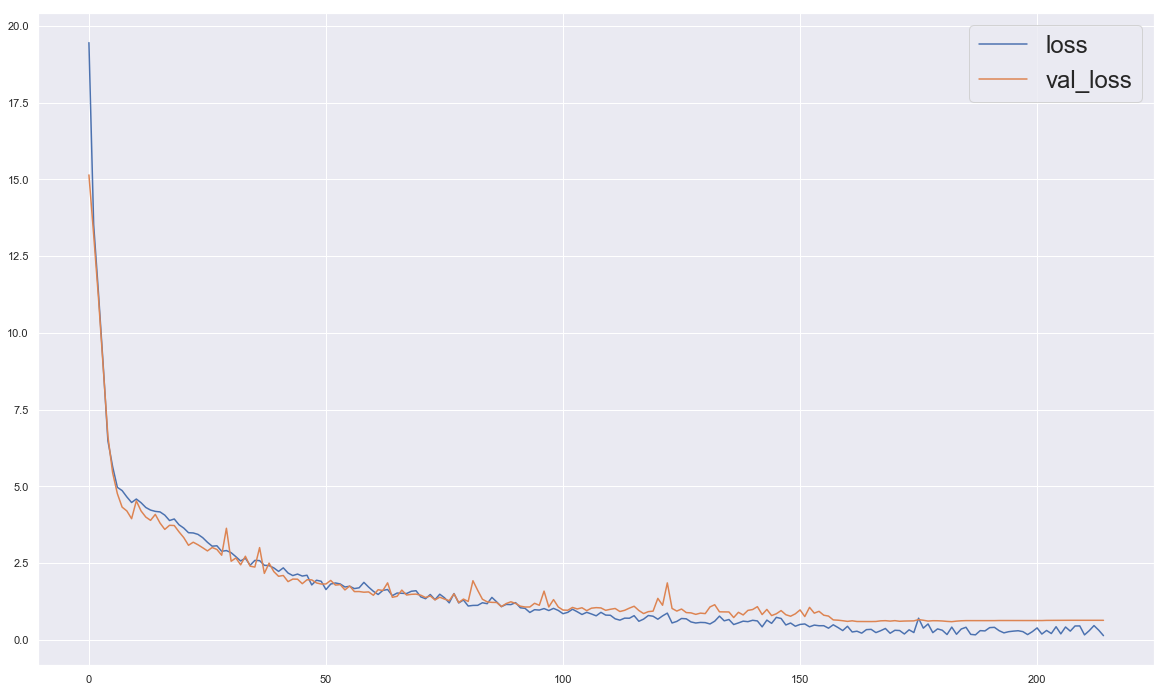

In [35]:
fig = plt.figure(figsize=(20,12))
plt.plot(data7['loss'], label='loss')
plt.plot(data7['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24})
plt.show()

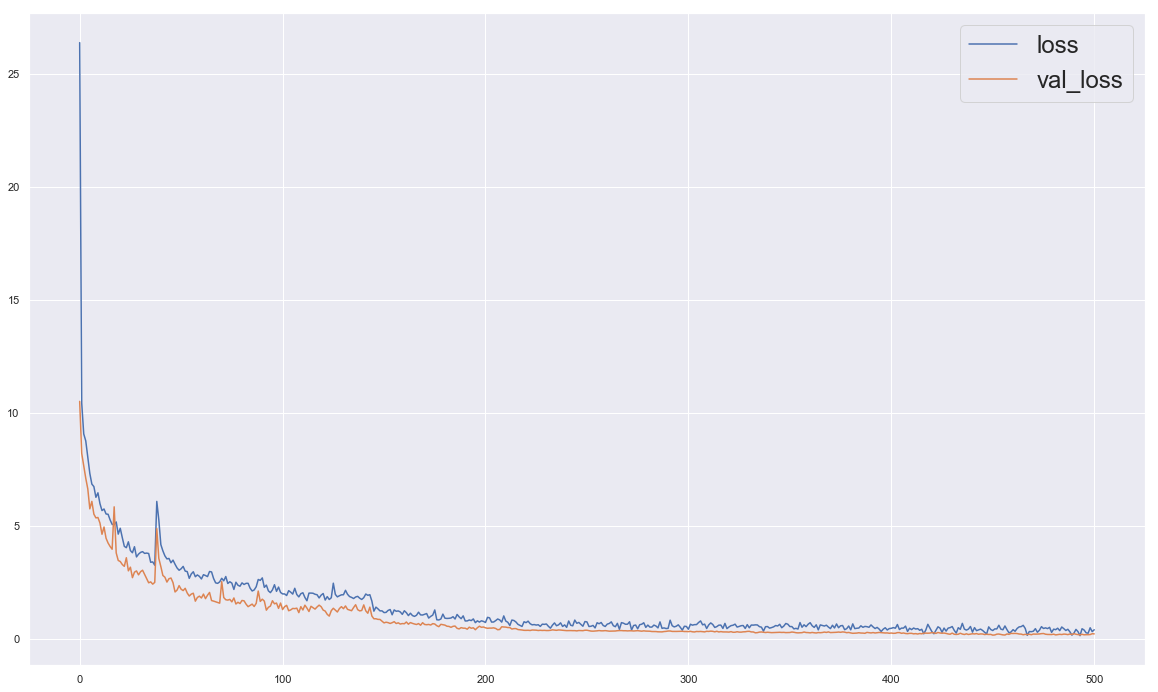

In [36]:
fig = plt.figure(figsize=(20,12))
plt.plot(data300['loss'], label='loss')
plt.plot(data300['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24})
plt.show()